In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import os
import cv2
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
import os
from PIL import Image
from keras.layers import Dense,Flatten,Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_path='/content/drive/MyDrive/Assignment Deep Learning/Train'
test_path='/content/drive/MyDrive/Assignment Deep Learning/Test '

In [6]:
batch_size = 32
img_width=224
img_height=224
img_size=128
epochs=50
NUM_CLASSES=2

In [7]:

data_generator = ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 180,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    validation_split = 0.2)

train_generator = data_generator.flow_from_directory(
    '/content/drive/MyDrive/Assignment Deep Learning/Train',
    target_size =(img_width, img_height),
    batch_size = batch_size,
    shuffle = True,
    class_mode = 'categorical',
    seed = 42,
    subset='training')

validation_generator = data_generator.flow_from_directory(
    '/content/drive/MyDrive/Assignment Deep Learning/Test',
    target_size =(img_width, img_height),
    batch_size = batch_size,
    shuffle = True,
    class_mode = 'categorical',
    seed = 42,
    subset='validation')

Found 84 images belonging to 1 classes.
Found 4 images belonging to 1 classes.


In [8]:
import numpy as np
from PIL import Image
import glob
import os

def load_images(root_folder, folder_names, target_size=(128, 128)):
    images = []
    labels = []

    for label_counter, folder_name in enumerate(folder_names):
        folder_path = os.path.join(root_folder, folder_name)

        if not os.path.isdir(folder_path):
            continue

        image_paths = glob.glob(os.path.join(folder_path, '*.jpg')) + glob.glob(os.path.join(folder_path, '*.png'))

        for img_path in sorted(image_paths):
            with Image.open(img_path) as img:
                img = img.resize(target_size)
                img_array = np.array(img)
                images.append(img_array)
                labels.append(label_counter)

    return np.array(images), np.array(labels)


In [9]:
selected_folders  = ['Class (1)', 'Class (2)']

In [10]:
X_train, y_train = load_images(train_path, selected_folders)
X_test, y_test = load_images(test_path, selected_folders)

In [11]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)

X_train (104, 128, 128, 3)
y_train (104,)


In [12]:
import tqdm
train_generator.reset()
X_train, y_train = next(train_generator)
for i in tqdm.tqdm(range(int(train_generator.n/batch_size)-1)):
  img, label = next(train_generator)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

(64, 224, 224, 3) (64, 1)


In [13]:
X_test, y_test = next(validation_generator)
for i in tqdm.tqdm(range(int(train_generator.n/batch_size)-1)):
  img, label = next(train_generator)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

(84, 224, 224, 3) (84, 1)


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to apply augmentation twice to each dataset
def augment_dataset(dataset):
    augmented_data = []
    for img in dataset:
        img = np.expand_dims(img, axis=0)  # Expanding dimensions for batch size
        for _ in range(1):  # Apply augmentation twice
            for batch in datagen.flow(img, batch_size=1):
                augmented_data.append(np.squeeze(batch))  # Remove the batch dimension
                break  # Stop the loop after one augmented image
    return np.array(augmented_data)

In [15]:

X_train_augmented = augment_dataset(X_train)
X_test_augmented = augment_dataset(X_test)

y_train_augmented = np.repeat(y_train, 1, axis=0)
y_test_augmented = np.repeat(y_test, 1, axis=0)

In [16]:
from sklearn.utils import shuffle


X_train_combined = np.concatenate((X_train, X_train_augmented))
y_train_combined = np.concatenate((y_train, y_train_augmented))

X_test_combined = np.concatenate((X_test, X_test_augmented))
y_test_combined = np.concatenate((y_test, y_test_augmented))



X_train_combined, y_train_combined = shuffle(X_train_combined, y_train_combined, random_state=42)
X_test_combined, y_test_combined = shuffle(X_test_combined, y_test_combined, random_state=42)

In [17]:
from keras.applications import vgg19


img_rows, img_cols = 224, 224
vgg = vgg19.VGG19(weights = 'imagenet',
                 include_top = False,
                 input_shape = (img_rows, img_cols, 3))

for layer in vgg.layers:
     layer.trainable = False


for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

80134624/80134624 [==============================] - 0s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 Conv2D False
11 MaxPooling2D False
12 Conv2D False
13 Conv2D False
14 Conv2D False
15 Conv2D False
16 MaxPooling2D False
17 Conv2D False
18 Conv2D False
19 Conv2D False
20 Conv2D False
21 MaxPooling2D False


In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model
def lw(bottom_model, num_classes):


    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.1)(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.1)(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.1)(top_model)
    top_model = Dense(num_classes,activation='sigmoid')(top_model)
    return top_model

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


num_classe = 1

FC_Head = lw(vgg, num_classe)

model = Model(inputs = vgg.input, outputs = FC_Head)

In [20]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import backend as K
metrics = [
        'accuracy',
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.SpecificityAtSensitivity(0.5),
        tf.keras.metrics.SensitivityAtSpecificity(0.5),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives(),]

In [22]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.1), loss = 'binary_crossentropy',metrics = metrics)

In [23]:
y_train.shape

(84, 1)

In [24]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('plants_vgg19_not-fined.h5',save_best_only=True),
    tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=3
    )
]
history = model.fit(X_train_combined,y_train_combined.astype('float32'),epochs=10,batch_size=32,validation_split=0.2,callbacks=callbacks)

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 0.9403 - auc: 0.0000e+00 - recall: 0.9403 - precision: 1.0000 - specificity_at_sensitivity: 0.0000e+00 - sensitivity_at_specificity: 0.0000e+00 - false_negatives: 8.0000 - false_positives: 0.0000e+00 - true_negatives: 0.0000e+00 - true_positives: 126.0000 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 168s 33s/step - loss: 0.1558 - accuracy: 0.9403 - auc: 0.0000e+00 - recall: 0.9403 - precision: 1.0000 - specificity_at_sensitivity: 0.0000e+00 - sensitivity_at_specificity: 0.0000e+00 - false_negatives: 8.0000 - false_positives: 0.0000e+00 - true_negatives: 0.0000e+00 - true_positives: 126.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_recall: 1.0000 - val_precision: 1.0000 - val_specificity_at_sensitivity: 0.0000e+00 - val_sensitivity_at_specificity: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 0.0000e+00 - val_true_positives: 34.0000
Epoch 2/10
5/5 [==============================] - 147s 30s/step - loss: 0.0000e+00 - accuracy: 1.0000 - auc: 0.0000e+00 - recall: 1.0000 - precision: 1.0000 - specificity_at_sensitivity: 0.0000e+00 - sensitivity_at_specificity: 0.0000e+00 - false_negatives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 0.0000e+00 - 

In [25]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 4s 4s/step - loss: 0.0000e+00 - accuracy: 1.0000 - auc: 0.0000e+00 - recall: 1.0000 - precision: 1.0000 - specificity_at_sensitivity: 0.0000e+00 - sensitivity_at_specificity: 0.0000e+00 - false_negatives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 0.0000e+00 - true_positives: 4.0000


[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0]

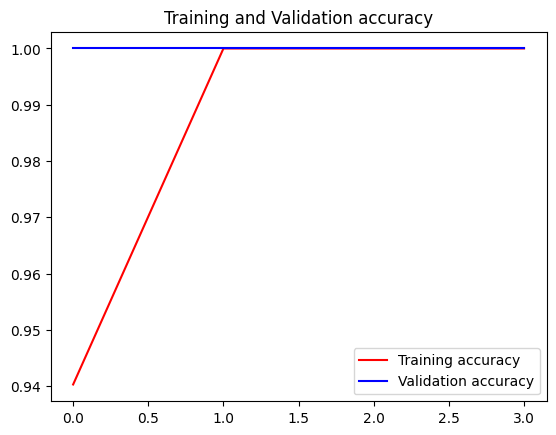

<Figure size 640x480 with 0 Axes>

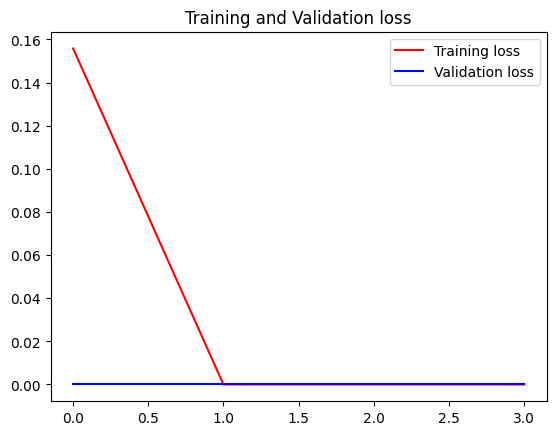

<Figure size 640x480 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label="Training accuracy")
plt.plot(epochs,val_acc,'b',label="Validation accuracy")
plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.title('Training and Validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [27]:
model.evaluate(X_test_combined,y_test_combined.astype('float32'))

1/1 [==============================] - 5s 5s/step - loss: 0.0000e+00 - accuracy: 1.0000 - auc: 0.0000e+00 - recall: 1.0000 - precision: 1.0000 - specificity_at_sensitivity: 0.0000e+00 - sensitivity_at_specificity: 0.0000e+00 - false_negatives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 0.0000e+00 - true_positives: 8.0000


[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0]